# TLV Modal Split

## Library Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

## Data Preprocessing

In [5]:
spreadsheet = '/Users/noamgal/Downloads/Ayalon_survey(1)/aas_1.06.csv'
df = pd.read_csv(spreadsheet)

/var/folders/82/8hysmmrd67z622hf9p3q3th80000gn/T/ipykernel_85264/1636189851.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(spreadsheet)


In [6]:
# Replace '--' with 0 in the 'Mode' column
df = df.replace('--', '0')
# Fill NaN values with -1 in TAZ columns
df['NewTazSource'] = df['NewTazSource'].fillna(-1)
df['TazSource'] = df['NewTaz'].fillna(-1)

# Convert string values to integers
df['Mode'] = df['Mode'].astype(int)

# Convert to integers
df['NewTazSource'] = df['NewTazSource'].astype(int)
df['NewTaz'] = df['NewTaz'].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333724 entries, 0 to 333723
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   HHID3         333724 non-null  int64  
 1   IndID3        333724 non-null  int64  
 2   SurveyDay     333724 non-null  int64  
 3   placeno       333724 non-null  int64  
 4   ID            333724 non-null  object 
 5   TypNdx        333724 non-null  int64  
 6   mainActivity  333724 non-null  int64  
 7   Mode          333724 non-null  int64  
 8   numAccomp     333724 non-null  object 
 9   accompType    333724 non-null  object 
 10  parkType      325717 non-null  object 
 11  ProDriver     333724 non-null  object 
 12  Arrive        333724 non-null  object 
 13  Depart        333724 non-null  object 
 14  NewTazSource  333724 non-null  int64  
 15  NewTaz        333724 non-null  int64  
 16  SourceCity    265632 non-null  object 
 17  TargetCity    333523 non-null  object 
 18  Trvl

## Mode Split Analysis

In [9]:
# dictionary for interpreting modes
code_dict = {
    0: 'Not Available',
    1: 'walk',
    2: 'bicycles',
    3: 'bus',
    4: 'service taxi',
    5: 'special taxi',
    6: 'train',
    7: 'driving a car',
    8: 'passengers in a car',
    9: 'motorcycle/scooter',
    10: 'Organized transportation',
    11: 'other',
    33: 'Professional travel, unknown bus type',
    45: 'professional travel, unknown taxi type',
    98: 'not applicable (first activity)',
    99: 'unknown'
}

# Replace the numbers in the 'Mode' column with the corresponding values from the dictionary
df['Mode'] = df['Mode'].map(code_dict)

In [10]:
print(df['Mode'].head())

0         Not Available
1                  walk
2                  walk
3    motorcycle/scooter
4              bicycles
Name: Mode, dtype: object


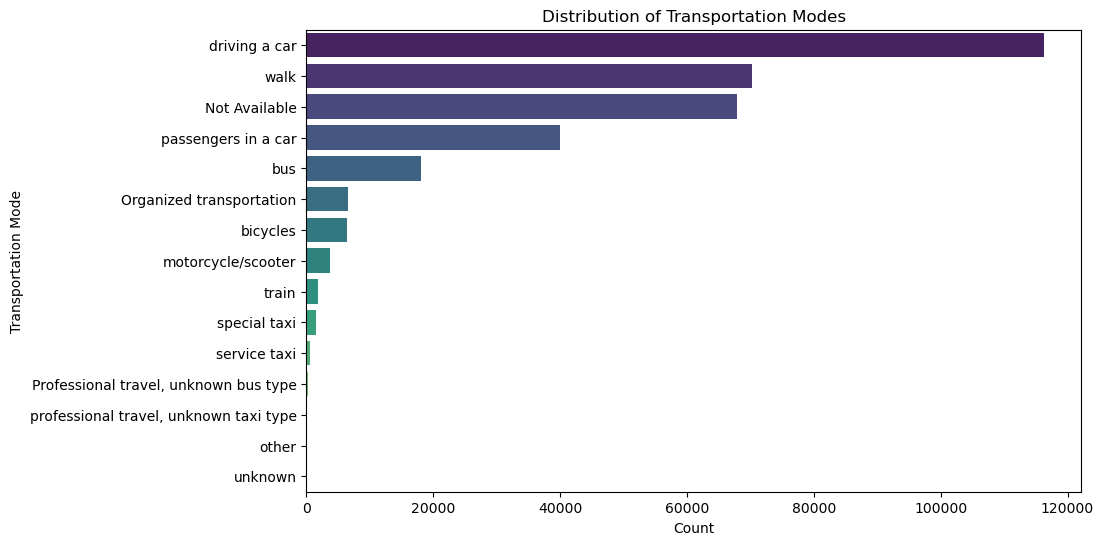

In [11]:
# Count the occurrences of each mode
mode_counts = df['Mode'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=mode_counts.values, y=mode_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Transportation Mode')
plt.title('Distribution of Transportation Modes')
plt.show()

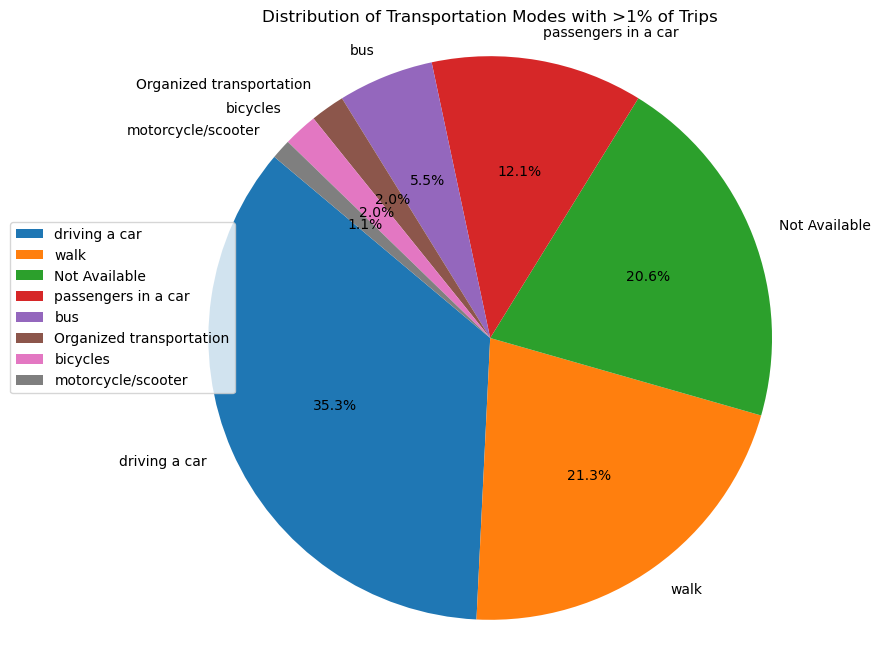

In [12]:
# Calculate percentages
total_trips = mode_counts.sum()
mode_percentages = mode_counts / total_trips * 100

# Filter modes with less than 1% of trips
filtered_modes = mode_percentages[mode_percentages >= 1]


# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(filtered_modes, labels=filtered_modes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Transportation Modes with >1% of Trips')
# Add legend
plt.legend(filtered_modes.index, loc="upper right", bbox_to_anchor=(0.1, 0.7))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## TAZ Map Generation

In [14]:
# Load the TAZ shapefile into a GeoDataFrame
taz_shapefile_path = "/Users/noamgal/Downloads/Ayalon_survey(1)/Shaked_shp/TAZold_TLVcity_clean.shp"
taz_gdf = gpd.read_file(taz_shapefile_path)



In [15]:
def analyze_by_taz(df, taz_column, data_column):
    """
    Analyze data based on unique TAZ values.

    Parameters:
        df (DataFrame): Input DataFrame.
        taz_column (str): Column name specifying TAZ values ('NewTaz' or 'NewTazSource').
        data_column (str): Column name of the data to analyze.

    Returns:
        DataFrame: DataFrame containing unique TAZ values in the first column and aggregated data in subsequent columns.
    """
    # Filter DataFrame to include only relevant columns
    filtered_df = df[[taz_column, data_column]]
    
    # Group by TAZ and aggregate data
    grouped_df = filtered_df.groupby(taz_column)[data_column].agg(['mean', 'median', 'sum', 'count']).reset_index()
    grouped_df.columns = [taz_column, f'{data_column}_mean', f'{data_column}_median', f'{data_column}_sum', f'{data_column}_count']
    
    return grouped_df

In [16]:
# Analyze Travel Distance by NewTaz
dest_trvl_dist = analyze_by_taz(df, 'NewTaz', 'TrvlDist')
print(dest_trvl_dist.head())

# Analyze Travel Distance by NewTazSource
origin_trvl_dist = analyze_by_taz(df, 'NewTazSource', 'TrvlDist')
print(origin_trvl_dist.head())

# Analyze Stay Time by NewTaz
dest_staytime = analyze_by_taz(df, 'NewTaz', 'StayTime')
print(dest_staytime.head())

# Analyze Travel Time by NewTaz
dest_trvltime = analyze_by_taz(df, 'NewTaz', 'TrvlTime')
print(dest_trvltime.head())

# Analyze Travel Time by NewTazSource
origin_trvltime = analyze_by_taz(df, 'NewTazSource', 'TrvlTime')
print(origin_trvltime.head())

   NewTaz  TrvlDist_mean  TrvlDist_median   TrvlDist_sum  TrvlDist_count
0       0      26.495845        12.100386  212046.245569            8003
1    1101       8.978750         5.362426     619.533739              69
2    1102       7.424522         4.265809    1113.678362             150
3    1103       7.052966         5.777354     197.483040              28
4    1104       2.487952         0.440279     860.831297             346
   NewTazSource  TrvlDist_mean  TrvlDist_median   TrvlDist_sum  TrvlDist_count
0            -1       0.000000         0.000000       0.000000               5
1             0       2.418793         0.000000  181690.069313           75116
2          1101       7.789025         6.218394     537.442754              69
3          1102       7.684051         5.154091    1091.135250             142
4          1103       6.198592         5.329972     167.361986              27
   NewTaz  StayTime_mean  StayTime_median  StayTime_sum  StayTime_count
0       0     15

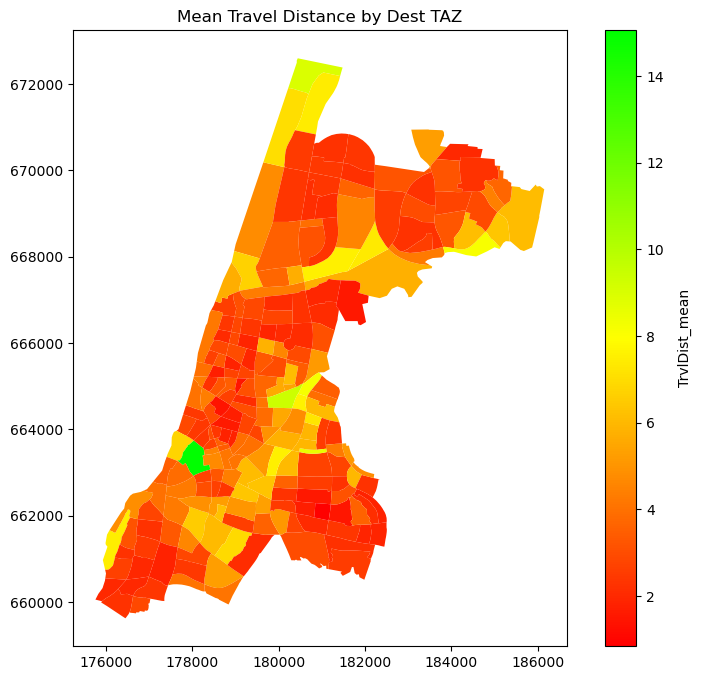

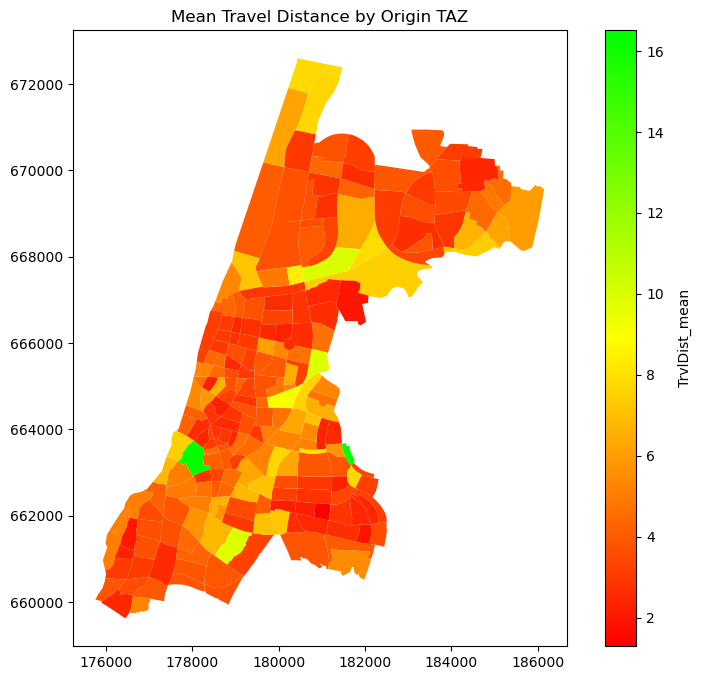

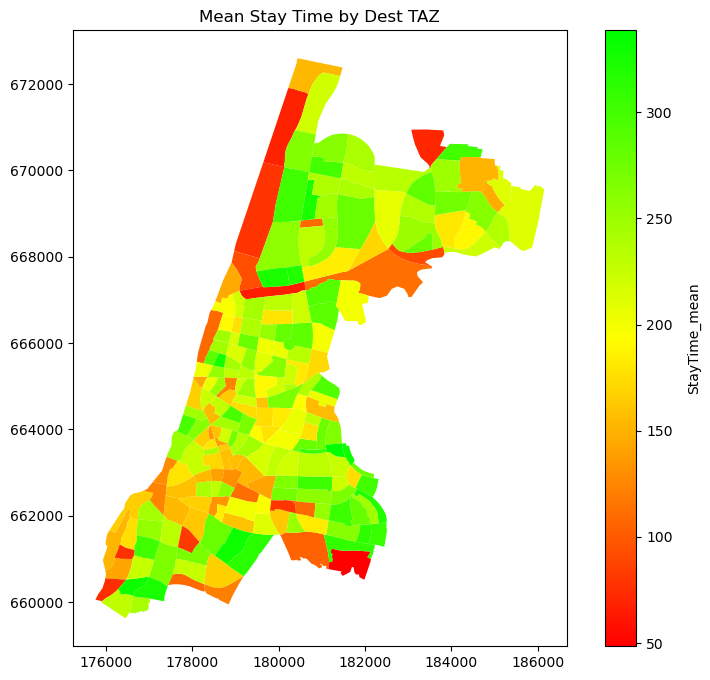

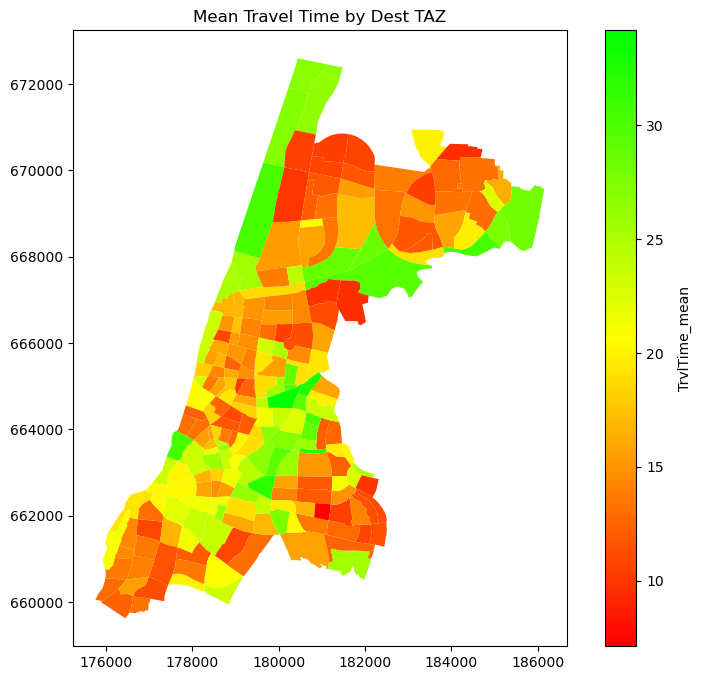

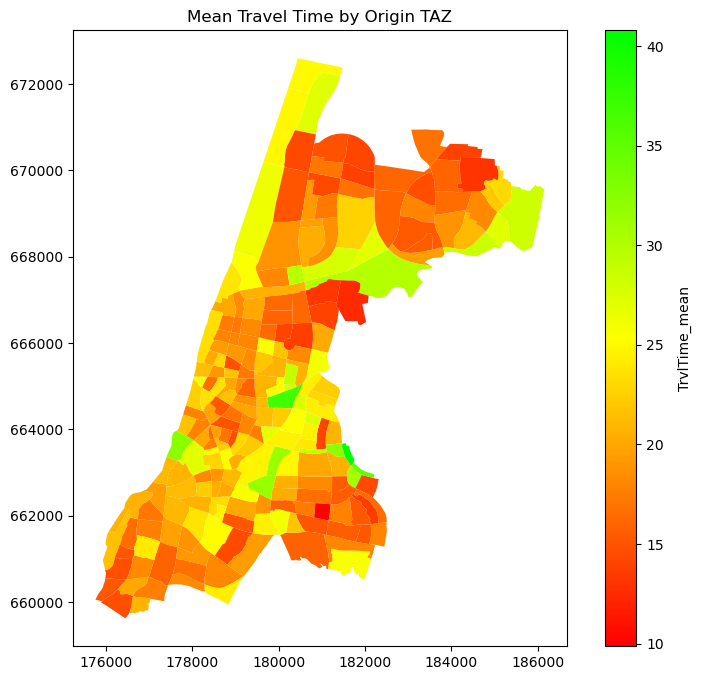

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

def plot_taz_map(merged_gdf, data_column, title):
    # conducts merge for either origin or dest tazs
    try:
        merged_gdf = taz_gdf.merge(merged_gdf, left_on='TAZV41', right_on='NewTazSource', how='left')
    except:
        merged_gdf = taz_gdf.merge(merged_gdf, left_on='TAZV41', right_on='NewTaz', how='left')

    # Define custom colormap from red to yellow to green
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # Red to yellow to green
    cmap_name = 'red_yellow_green'
    red_yellow_green_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

    # Plot the merged GeoDataFrame with graduated symbology based on data column
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    merged_gdf.plot(column=data_column, cmap=red_yellow_green_cmap, legend=False, ax=ax)

    # Customize legend
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=merged_gdf[data_column].min(), vmax=merged_gdf[data_column].max()), cmap=red_yellow_green_cmap), ax=ax)
    cbar.set_label(data_column, rotation=90, labelpad=10)

    # Set plot title
    ax.set_title(title)

    plt.show()
    

# Call the function for each DataFrame
plot_taz_map(dest_trvl_dist, 'TrvlDist_mean', 'Mean Travel Distance by Dest TAZ')
plot_taz_map(origin_trvl_dist, 'TrvlDist_mean', 'Mean Travel Distance by Origin TAZ')
plot_taz_map(dest_staytime, 'StayTime_mean', 'Mean Stay Time by Dest TAZ')
plot_taz_map(dest_trvltime, 'TrvlTime_mean', 'Mean Travel Time by Dest TAZ')
plot_taz_map(origin_trvltime, 'TrvlTime_mean', 'Mean Travel Time by Origin TAZ')


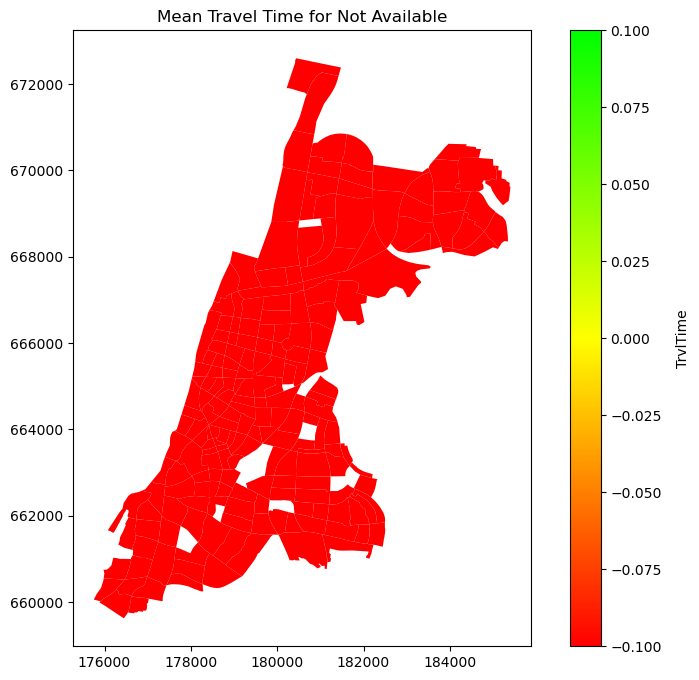

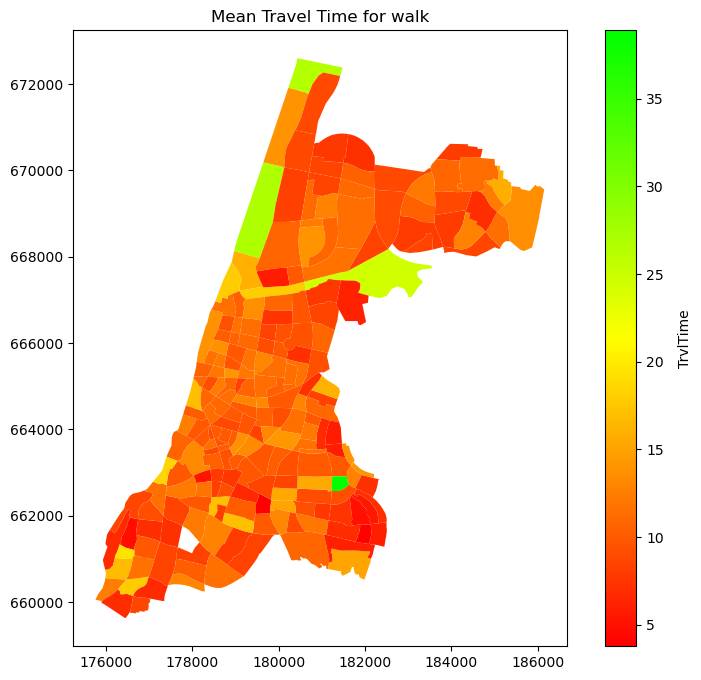

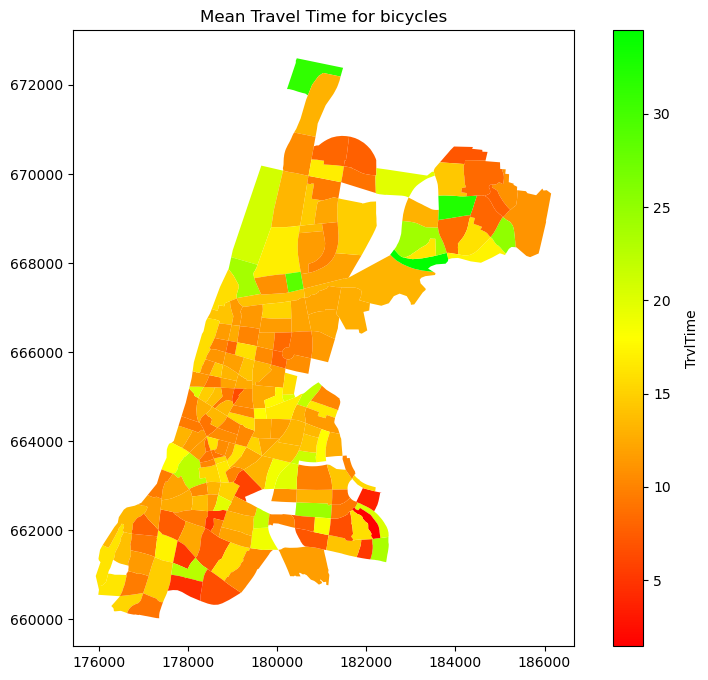

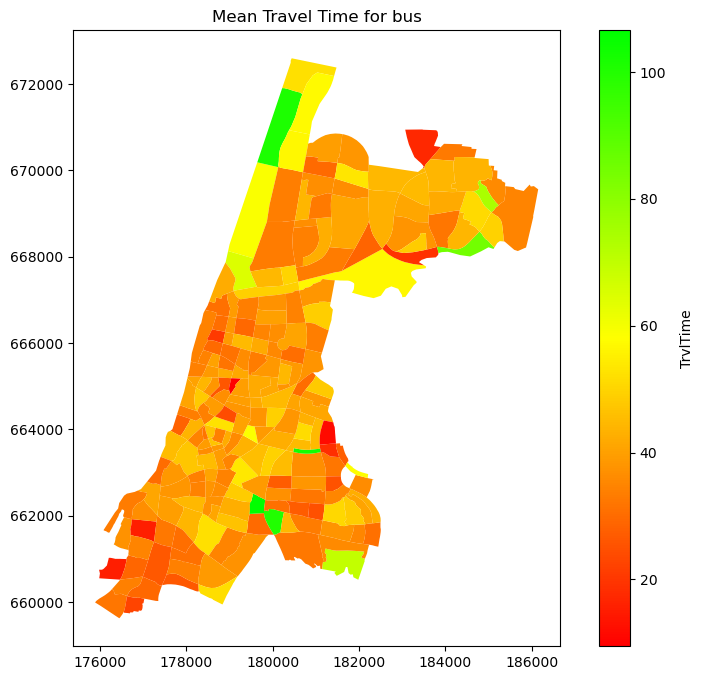

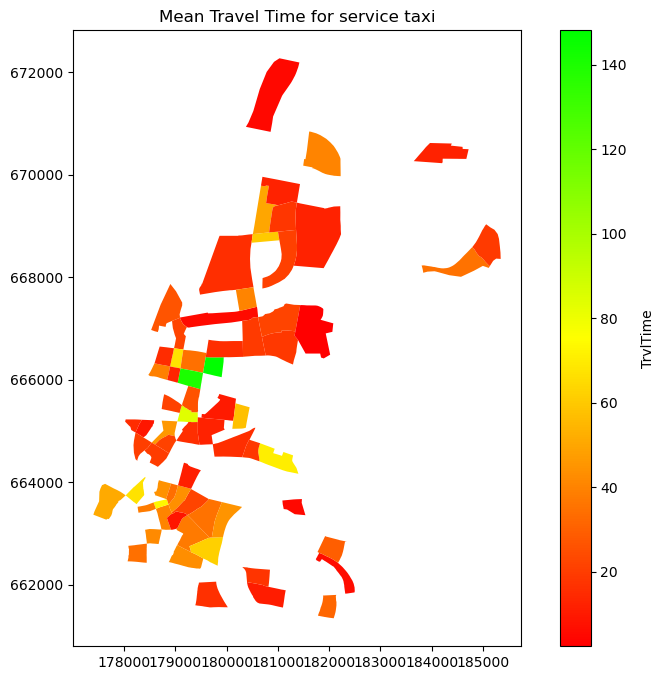

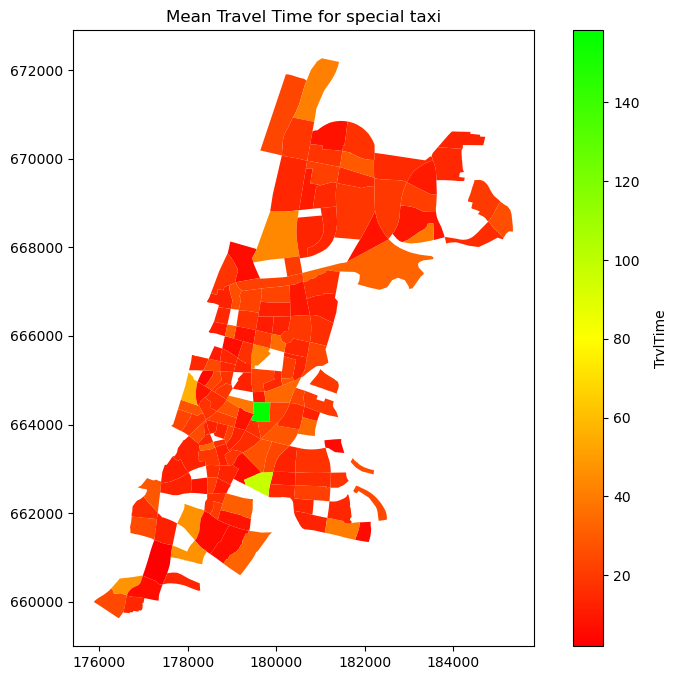

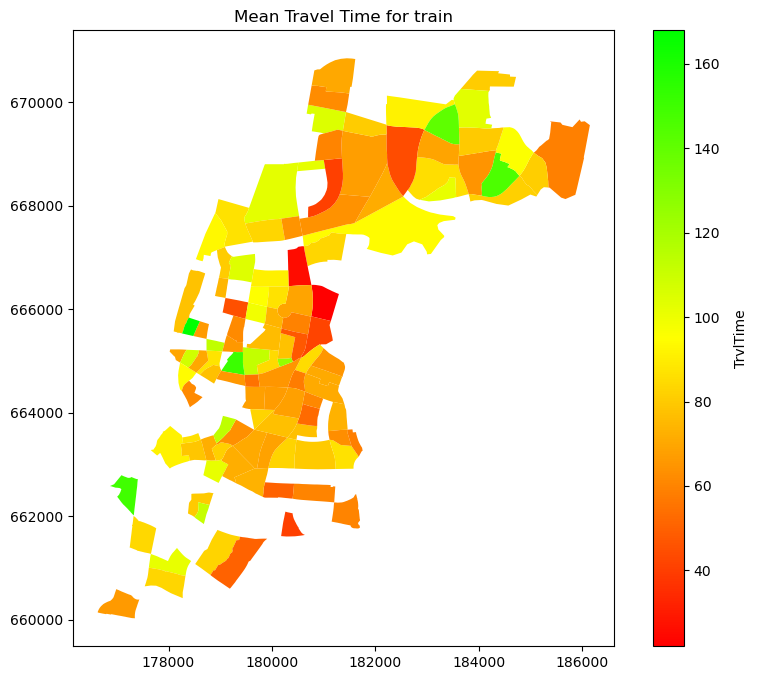

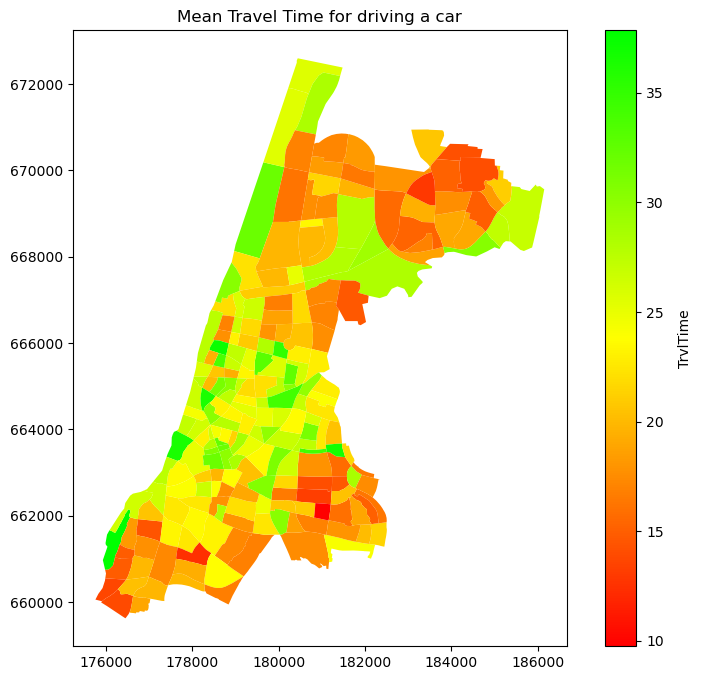

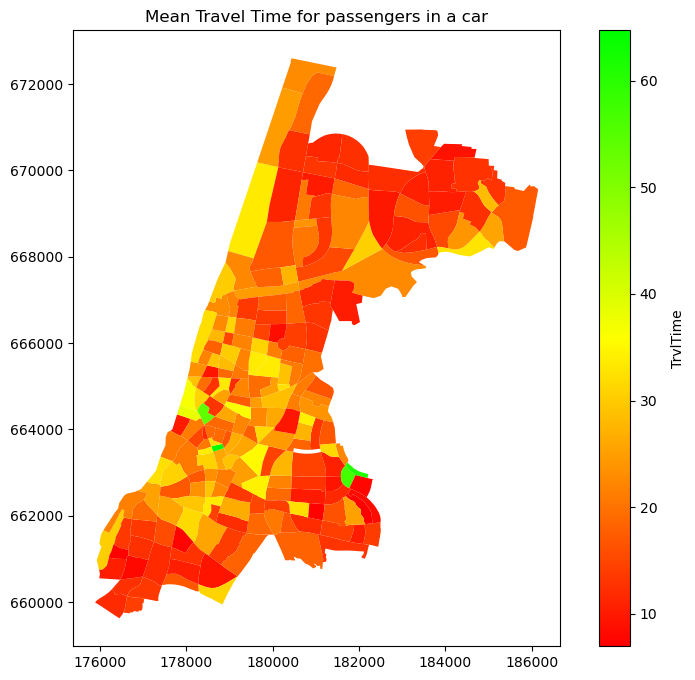

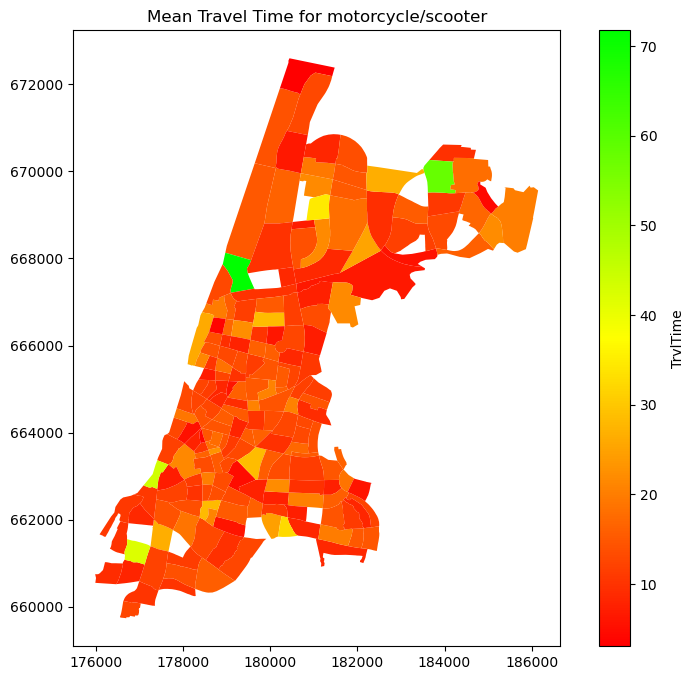

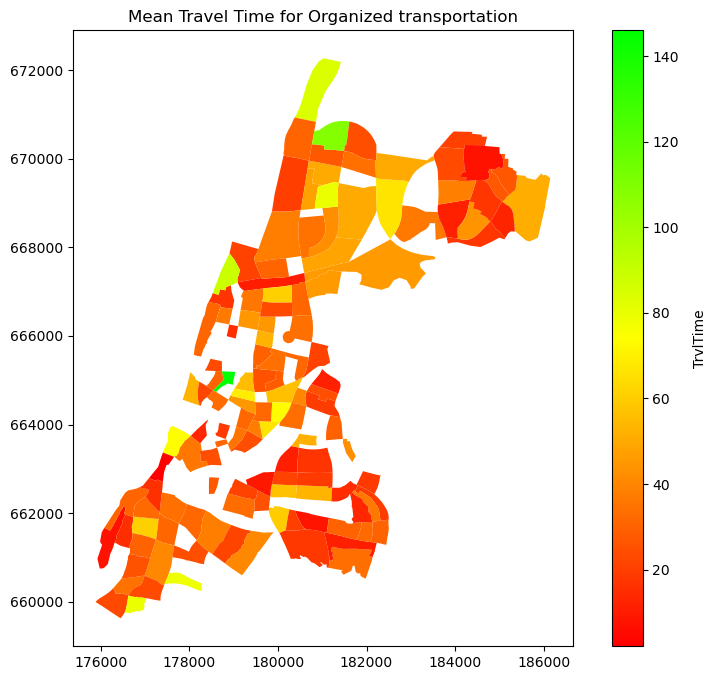

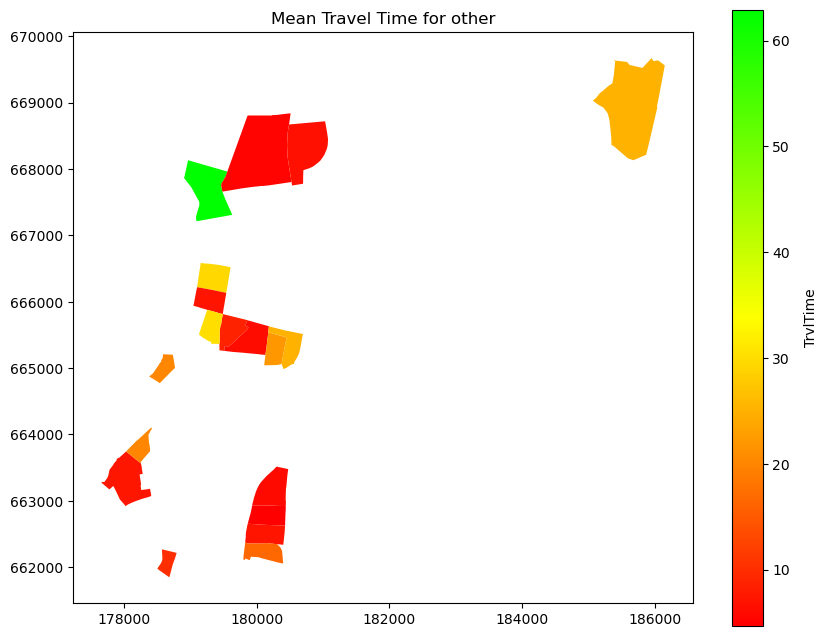

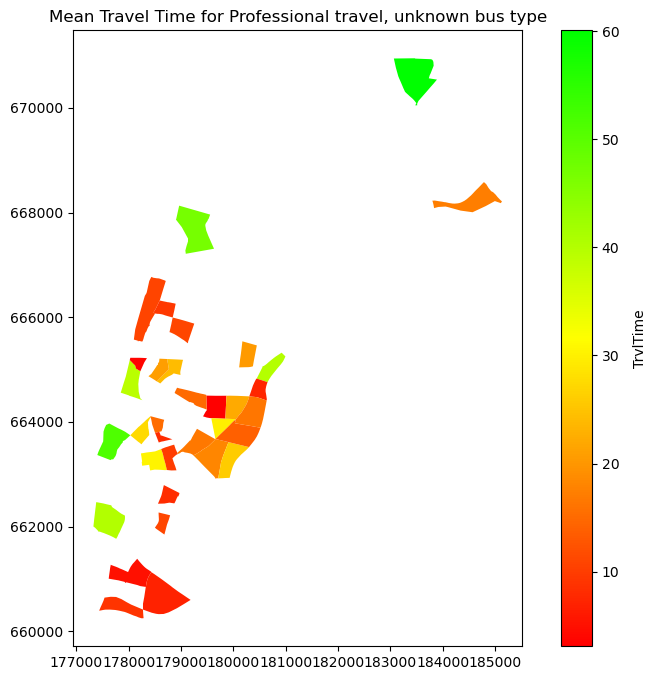

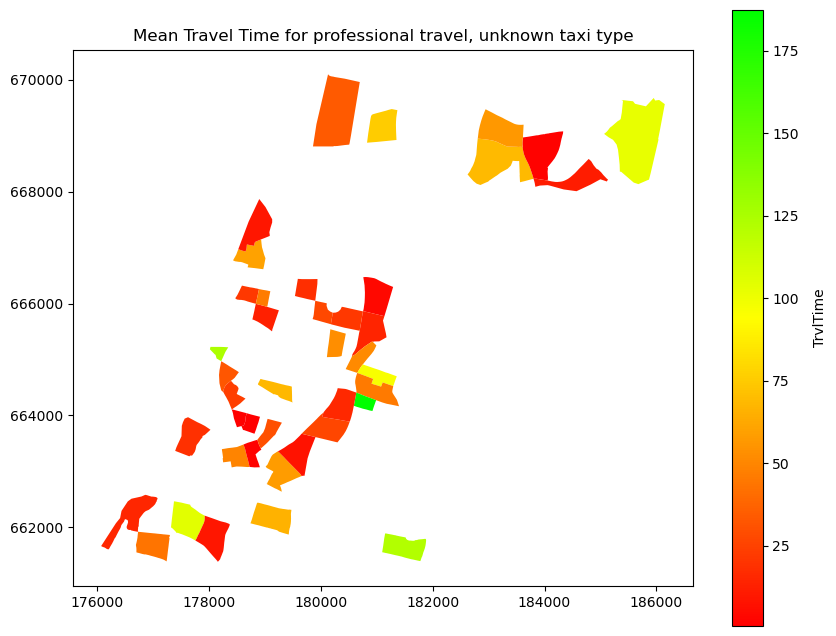

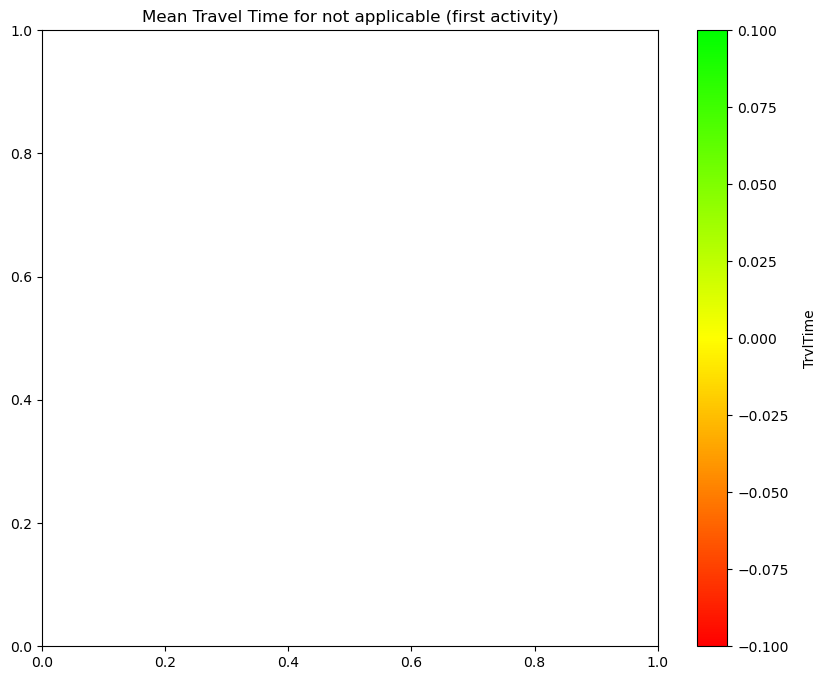

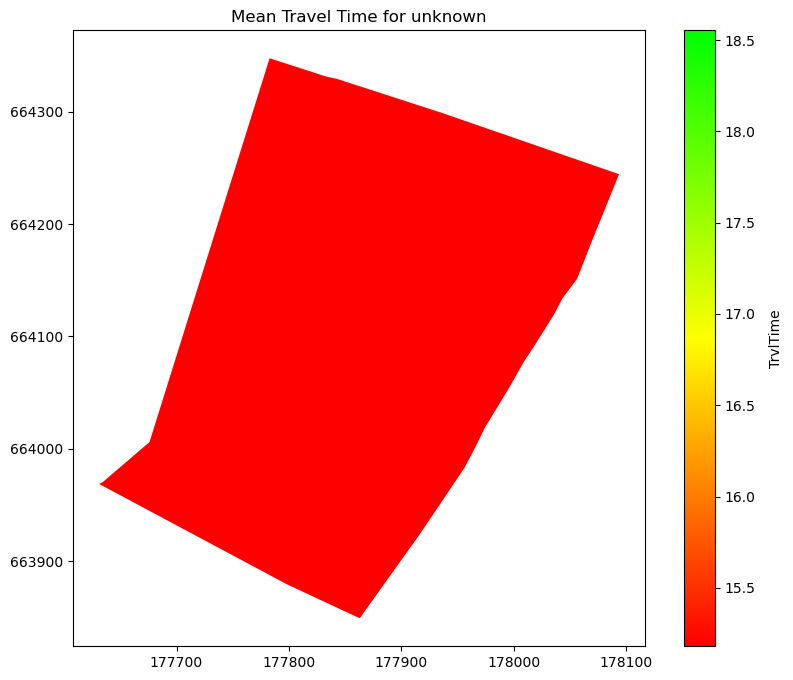

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

def plot_mode_map(taz_gdf, taz_column, merged_gdf, data_column, title):
    # conducts merge for either origin or dest tazs
    try:
        merged_gdf = taz_gdf.merge(merged_gdf, left_on='TAZV41', right_on='NewTazSource', how='left')
    except:
        merged_gdf = taz_gdf.merge(merged_gdf, left_on='TAZV41', right_on='NewTaz', how='left')

    # Define custom colormap from red to yellow to green
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # Red to yellow to green
    cmap_name = 'red_yellow_green'
    red_yellow_green_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

    # Plot the merged GeoDataFrame with graduated symbology based on data column
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    merged_gdf.plot(column=data_column, cmap=red_yellow_green_cmap, legend=False, ax=ax)

    # Customize legend
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=merged_gdf[data_column].min(), vmax=merged_gdf[data_column].max()), cmap=red_yellow_green_cmap), ax=ax)
    cbar.set_label(data_column, rotation=90, labelpad=10)

    # Set plot title
    ax.set_title(title)

    plt.show()

# Define a list of modes from the dictionary
modes = list(code_dict.values())

# Iterate over each mode
for mode in modes:
    # Filter the DataFrame for the current mode
    mode_df = df[df['Mode'] == mode]
    
    # Aggregate data by TAZ (for example, calculating mean travel time)
    mode_aggregated = mode_df.groupby('NewTaz').agg({'TrvlTime': 'mean'}).reset_index()
    
    # Plot choropleth map
    plot_mode_map(taz_gdf, 'TAZV41', mode_aggregated, 'TrvlTime', f'Mean Travel Time for {mode}')
